In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer

In [3]:
df = pd.read_csv('/content/olid-training-v1.0.tsv', sep='\t')

# Remove unnecessary columns
df = df.drop(['id', 'subtask_a', 'subtask_b'], axis=1)

# Drop missing values
df = df.dropna()

# Encode the labels
labels = {'OTH': 0, 'GRP': 1, 'IND': 2}
df['subtask_c'] = df['subtask_c'].apply(lambda x: labels[x])

In [4]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['tweet'], df['subtask_c'], test_size=0.2, random_state=42)

In [5]:
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# Tokenize the training and validation sets
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True)

In [7]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.values
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val.values
))

In [8]:
# Batch the datasets
train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)

In [9]:
# Define the base model
base_model = TFAutoModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [10]:
# Define the meta-learner model
meta_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(768,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [11]:
# Define the loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [12]:
# Define the training loop
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        base_output = base_model(inputs)['last_hidden_state'][:, 0, :]
        meta_output = meta_model(base_output)
        loss = loss_fn(labels, meta_output)
    gradients = tape.gradient(loss, meta_model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, meta_model.trainable_weights))
    return loss

In [13]:
# Train the model
for epoch in range(20):
    for inputs, labels in train_dataset:
        loss = train_step(inputs, labels)
    print('Epoch', epoch+1, '- Loss:', loss.numpy())

Epoch 1 - Loss: 0.9355709
Epoch 2 - Loss: 0.8890973
Epoch 3 - Loss: 0.8732193
Epoch 4 - Loss: 0.8396506
Epoch 5 - Loss: 0.81242687
Epoch 6 - Loss: 0.7829135
Epoch 7 - Loss: 0.74494857
Epoch 8 - Loss: 0.70022446
Epoch 9 - Loss: 0.6478924
Epoch 10 - Loss: 0.5960269
Epoch 11 - Loss: 0.5291112
Epoch 12 - Loss: 0.47142792
Epoch 13 - Loss: 0.4147407
Epoch 14 - Loss: 0.34166577
Epoch 15 - Loss: 0.2861055
Epoch 16 - Loss: 0.23123343
Epoch 17 - Loss: 0.1990105
Epoch 18 - Loss: 0.16511847
Epoch 19 - Loss: 0.12253139
Epoch 20 - Loss: 0.108051606


In [14]:
# Evaluate the model on the validation set
true_labels = []
predictions = []
for inputs, labels in val_dataset:
    base_output = base_model(inputs)['last_hidden_state'][:, 0, :]
    meta_output = meta_model(base_output).numpy()
    predicted_labels = np.argmax(meta_output, axis=1)
    true_labels.extend(labels.numpy())
    predictions.extend(predicted_labels)

from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.11      0.03      0.04        73
           1       0.54      0.63      0.58       202
           2       0.81      0.84      0.82       501

    accuracy                           0.71       776
   macro avg       0.48      0.50      0.48       776
weighted avg       0.67      0.71      0.69       776



In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

# Define class labels for visualization
class_labels = ['OTH', 'GRP', 'IND']

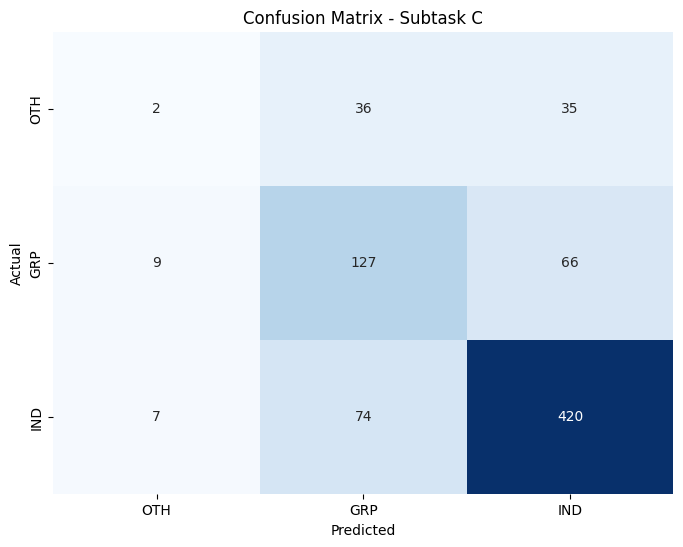

In [16]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Subtask C')
plt.show()

In [18]:
from sklearn.manifold import TSNE

# Obtain the BERT embeddings for the validation set
val_inputs = {key: np.array(val_encodings[key]) for key in val_encodings.keys()}
val_embeddings = base_model.predict(val_inputs)['last_hidden_state'][:, 0, :]

25/25 [==============================] - 11s 280ms/step


In [19]:
# Apply t-SNE to the BERT embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(val_embeddings)

In [20]:
# Create a DataFrame for t-SNE embeddings
tsne_df = pd.DataFrame(data=tsne_embeddings, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Label'] = true_labels

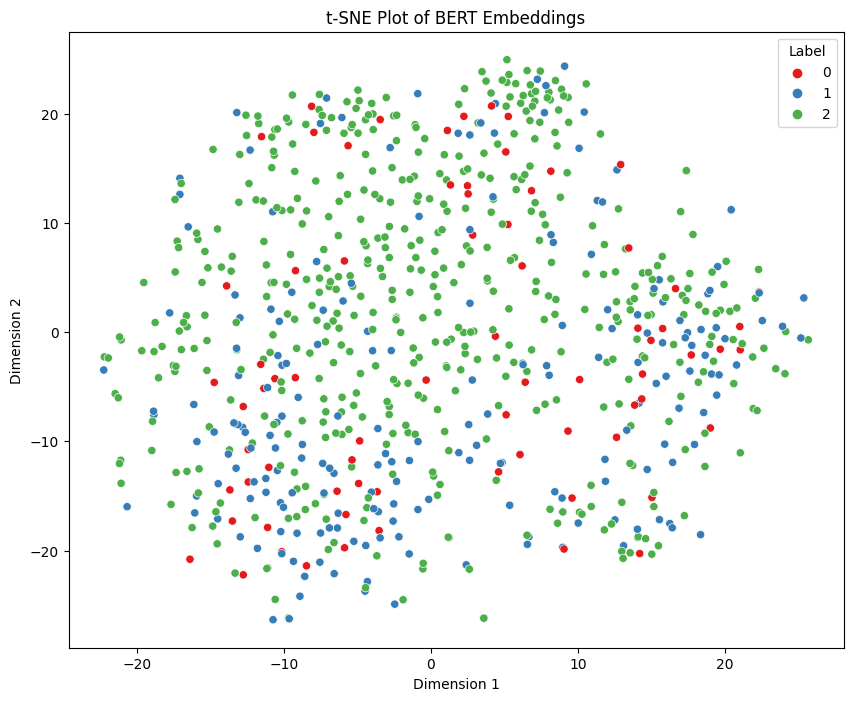

In [21]:
# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='Label', palette='Set1')
plt.title('t-SNE Plot of BERT Embeddings')
plt.show()